# Introduction to Data Science, CS 5963 / Math 3900
*CS 5963 / MATH 3900, University of Utah, http://datasciencecourse.net/* 

## Lecture 11: Clustering


In this lecture, we will introduce clustering, and **unsupervised** learning technique. 

Recommended Reading: ISLR, Ch. 10.1, 10.3.; Grus, Ch. 19.

 as well as on the [scikit learn documentation](http://scikit-learn.org/stable/modules/clustering.html#k-means).
 
 https://github.com/cs109/2015/blob/master/Lectures/19-Clustering.pdf

## What is Clustering?

Clustering is an unsupervised technique, that means we have **no labels** in the data. 

We try to determine groups only based on the data. 

Clustering is very common for tabular data, networks, etc. It is a critical tool in many science domains, such as biology. 



In [1]:
import numpy as np
from sklearn import metrics
import pandas as pd

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#import statsmodels.formula.api as sm



import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Create color maps
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## K-Means


### K-Means with SciKit Learn

SciKit learn has [a nice k-means implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) which we'll use to cluster various artificial datasets first.

The algorithm is as following: 

**Input:** set of records $x_1 … x_n$, and $k$ (nr clusters).  

Pick $k$ starting points as centroids $c_1 … c_k$  

While not converged:
 1. for each point $x_i$  find closest centroid $c_j$
    * for every $c_j$ calculate distance $D(x_i , c_j)$
    * assign $x_i$  to cluster $j$ defined by smallest distance
 2. for each cluster $j$, compute a new centroid $c_j$ by calculating the average of all $x_i$ assigned to cluster $j$
 
Repeat until convergence, e.g., 
 * no point has changed cluster
 * distance between old and new centroid below threshold
 * number of max iterations reached
 
See [this website](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/) for an interactive illustration.

### Properties

K-Means minimizes the aggregate intra-cluster distance (inertia) to find a global minimum:

$$\underset{C}{arg min}\sum_{i=1}^{k}\sum_{x \in C_i}\|x - \mu_i\|^2$$

Where $\mu_i$ is the mean of points in $C_i$.

This corresponds to the total squared distance from each point to the center of its cluster. If the Euclidean distance is used, as here, this corresponds to the variance. 

In practice, K-Means is implemented as [Lloyd's algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) (see above) which isn't guaranteed to find a global minimum, instead it is guaranteed to converge to a local minimum! 

For a specific set of clusters, this inertia is also a measure of how internally coherent clusters are. Two different clustering solutions can be compared by comparing their overall inertia.  

### K-Means in scikit learn

Let's try this with scikit learn. First, we'll create data using a function that generates [gaussian blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs).

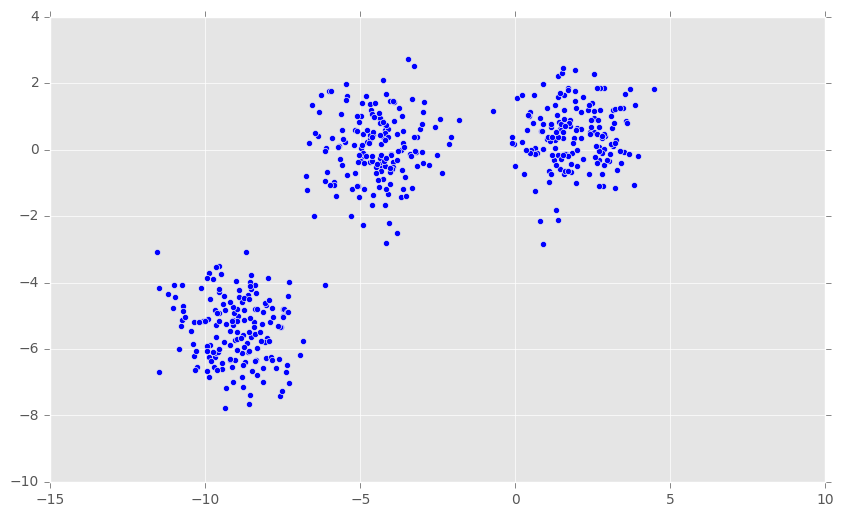

In [2]:
n_samples = 500
random_state = 170
# make_blobs generates gaussian blobs, we create 3 blobs
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)

# plot data
plt.scatter(X[:, 0], X[:, 1],  marker="o")
plt.show()

Now we run the scikit learn  [KMeans implementation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) with k=3, and the configuration that follows the algorithm described above for only a single iteration!

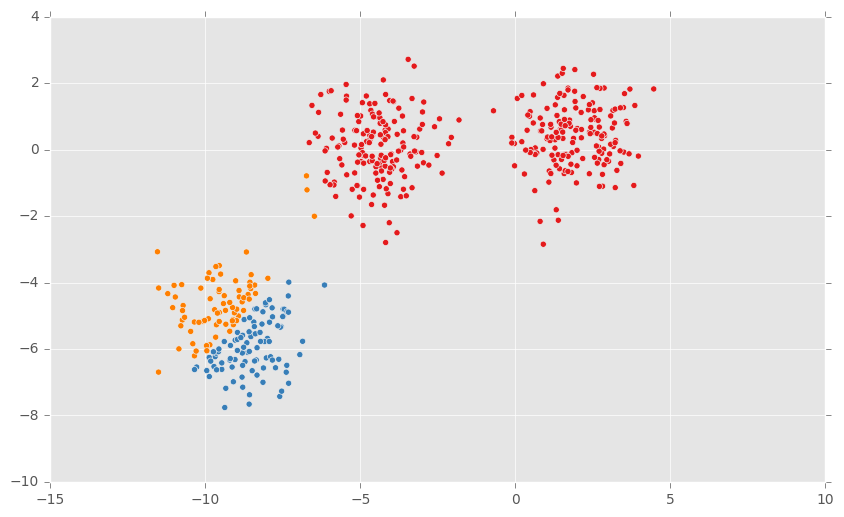

In [3]:
# the dumbest possible version of k-means with exactly one run
# this is essentially just random initialization + assign closets points
y_pred = KMeans(n_clusters=3, n_init=1, init='random', max_iter=1).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

What we get here is highly dependent on the initial, random, placement of the centroids. All this does is randomly place k centroids, and assign all the closest points to it. 

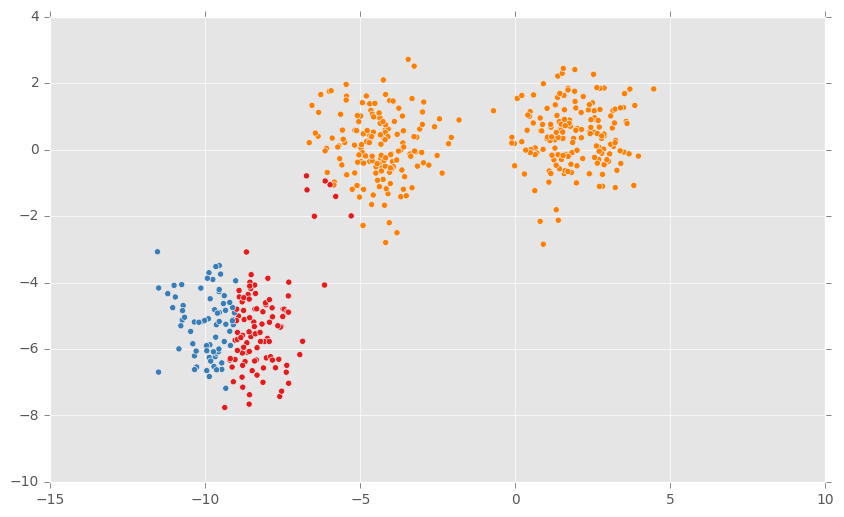

In [4]:
# the dumbest possible version of k-means
# after three iterations we already see some improvement
y_pred = KMeans(n_clusters=3, n_init=1, init='random', max_iter=3).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

 * `n_init`: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. Defaults to 10.

 * `init`
     * `random` picks k random points for inital cluster seeds
     * `k-means++` (the default) uses the [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) [algorithm](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf) to"spread out" the inital seeds: the first cluster center is chosen uniformly at random from the data points that are being clustered, after which each subsequent cluster center is chosen from the remaining data points with probability proportional to its squared distance from the point's closest existing cluster center.

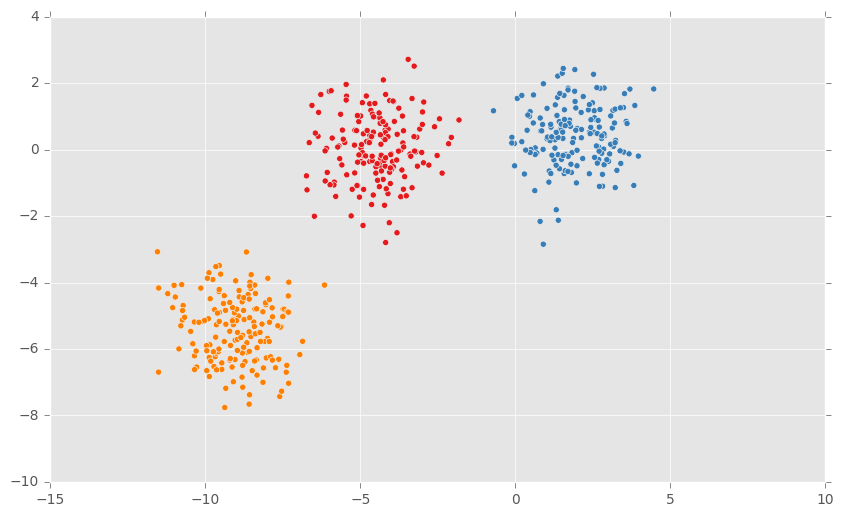

In [5]:
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)
# For this simple dataset using k-means++ initalization and 10 runs of k-means,
# even a max_iter of 1 yields good results.
y_pred = KMeans(n_clusters=3, max_iter=1).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

### K-Means properties

Up to now, we've applied the algorithm only to nice, Gaussian blobs of equal size. The measure of Inertia, however, makes the assumption that clusters are 

 * Convex
 * isotropic (uniform in all orientations)
 
Let's see what the algorithm does for point sets that 

 * vary in size
 * vary in variance
 * are anisotropic 
 * are convex
 
#### Varying Size

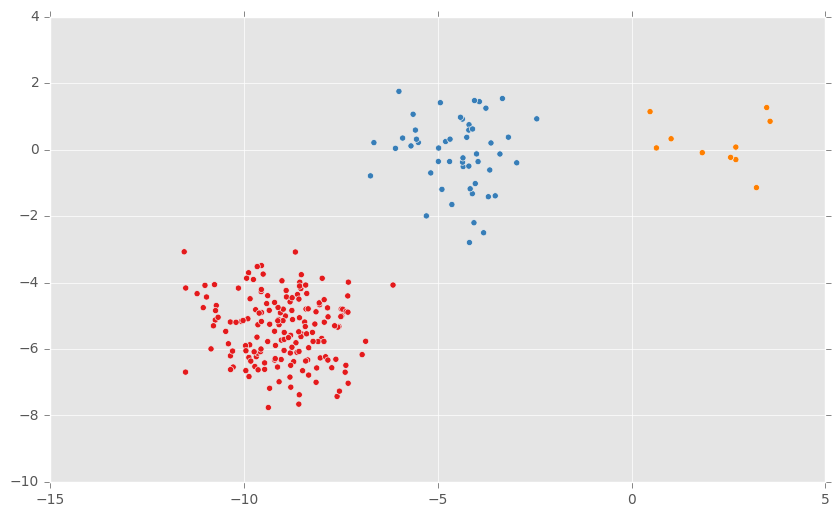

In [6]:
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:200], X[y == 1][:50], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3).fit_predict(X_filtered)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

K-Means does fine with unevenly sized blobs. 

### Anisotropic point clouds

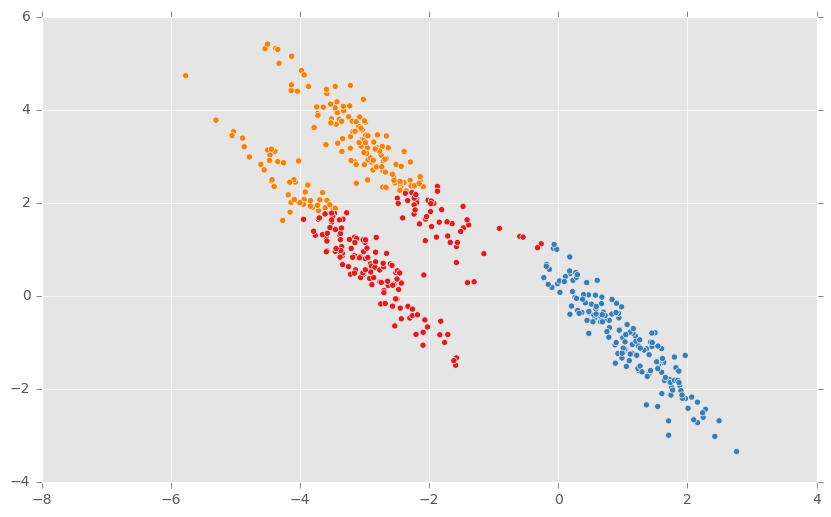

In [7]:
# Anisotropicly distributed data
transformation = [[ 0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

Here we see a clear weakness of k-means, it doesn't work well for anisotropic point clouds. 

### Convex point clouds

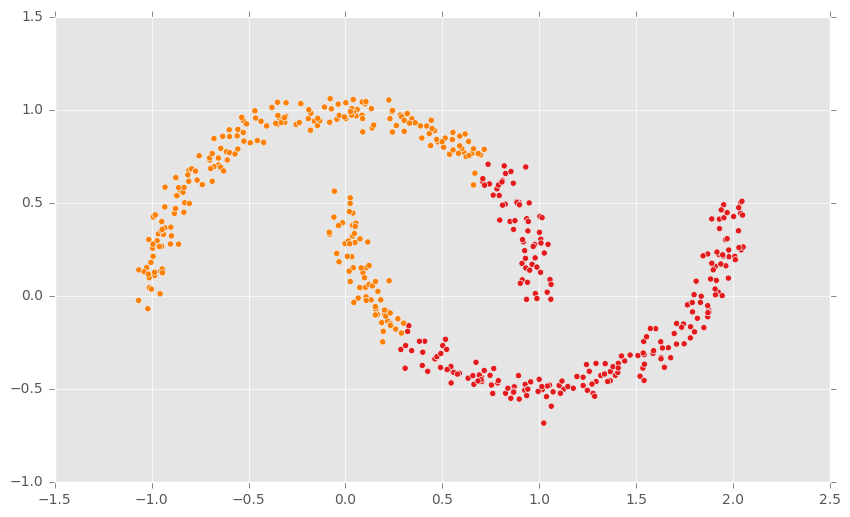

In [8]:
X_moons, y = make_moons(n_samples=500, noise=.05)

y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X_moons)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

### K-Means Limitations

More about k-means limitations [here](http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means). 




### Choosing K
K-Means is very sensitive to the correct number of k

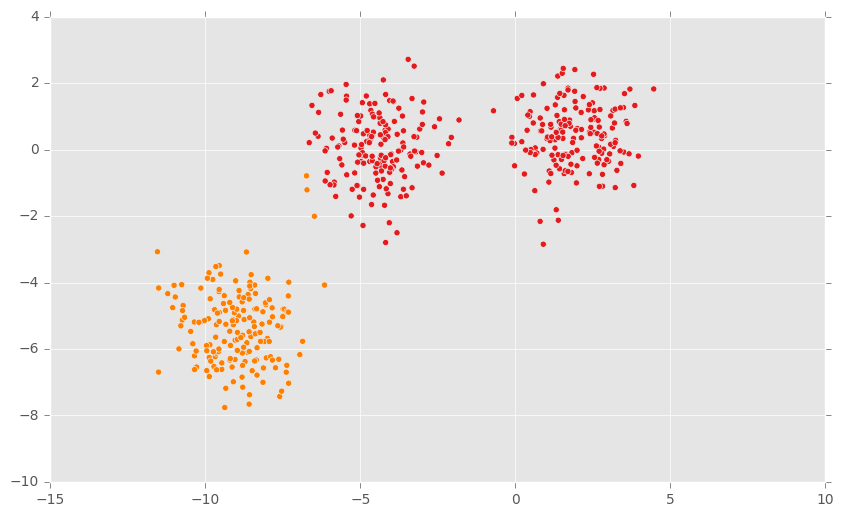

In [9]:
X, y = make_blobs(n_samples=n_samples, centers=3, random_state=random_state)
y_pred = KMeans(n_clusters=2).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

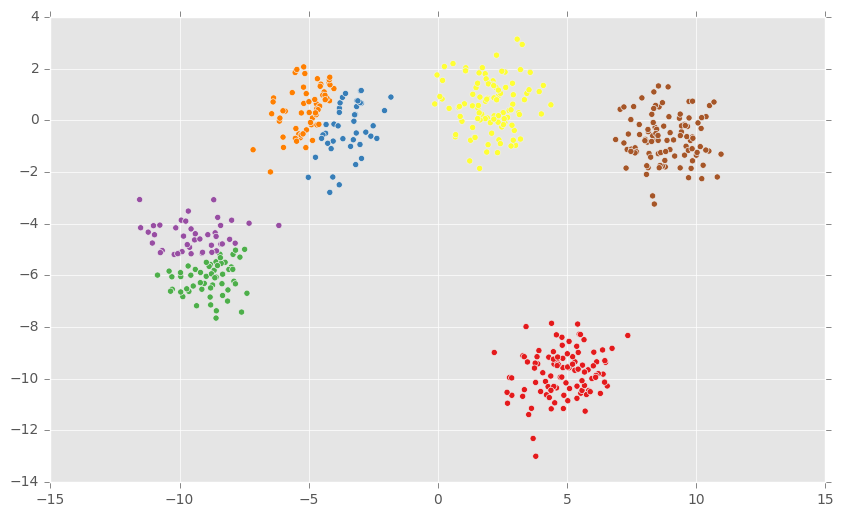

In [10]:
X, y = make_blobs(n_samples=n_samples, centers=5, random_state=random_state)
y_pred = KMeans(n_clusters=7).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", cmap=cmap)
plt.show()

**How do you choose K?**

 * Visualization, comparison
 * [Shiloutte Analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
 * Looking for at which K the inertia tapers off. 
 
 Let's take a look at the last and simplest approach:


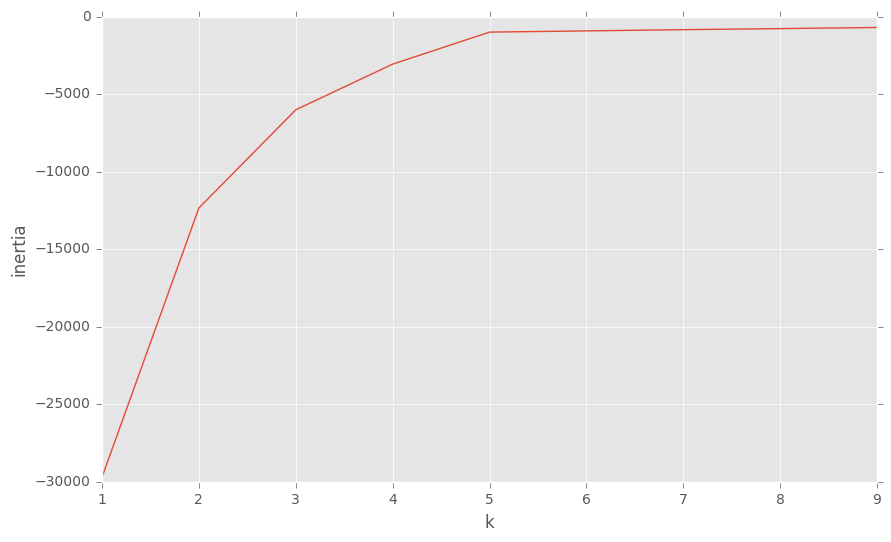

In [11]:
scores = []
ks = []

# clustering for k = 1 to k = 10
for i in range(1,10):
    model = KMeans(n_clusters=i)
    model.fit_predict(X)
    scores.append(model.score(X))
    ks.append(i)

plt.plot(ks, scores)
plt.ylabel('inertia')
plt.xlabel('k')
plt.show()

We can see that the inertia is large for k = 1 and continues to shrink, up until 5, after which it tapers of and gets only marginally smaller. 

Note that the scikit learn implementation returns negative values ("opposites of the k-means objective") as scores here.

What we're interested in is the k where the curve tapers of - before that we still reduce the error a lot, indicating that k is to small. After that, the inertia doesn't change much, indicating that individual clusters are split. 

# Higher dimensional Example

We're going to look at how well k-means does in a higher dimensional example, our well known Iris dataset. 

First, let's load the dataset and look at the first two dimensions. 

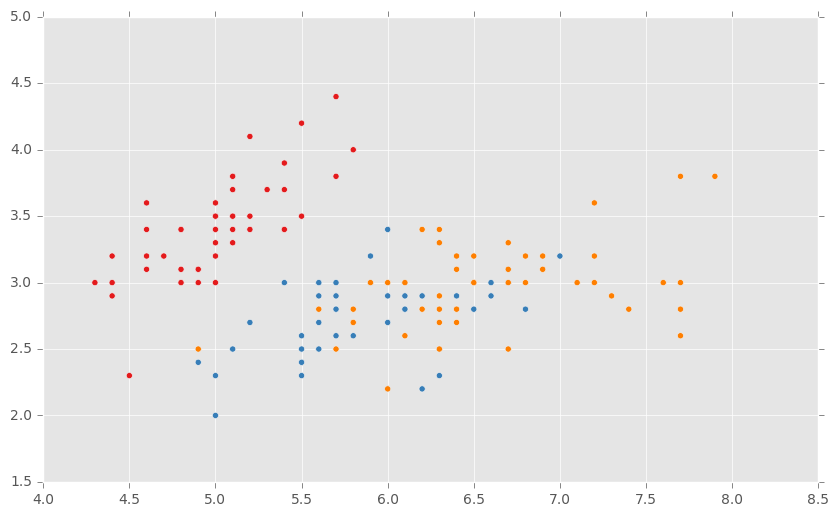

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [12]:
iris = load_iris()
X = iris.data
Y_iris_gt = iris.target

plt.scatter(X[:, 0], X[:, 1], c=Y_iris_gt,  marker="o", cmap=cmap)
plt.show()
print(Y_iris_gt)

This isn't very discernible in these two dimensions (we'll see how we can better plot this once we've talked about PCA). 

Now let's run a clustering algorithm on all dimension and plot again. 

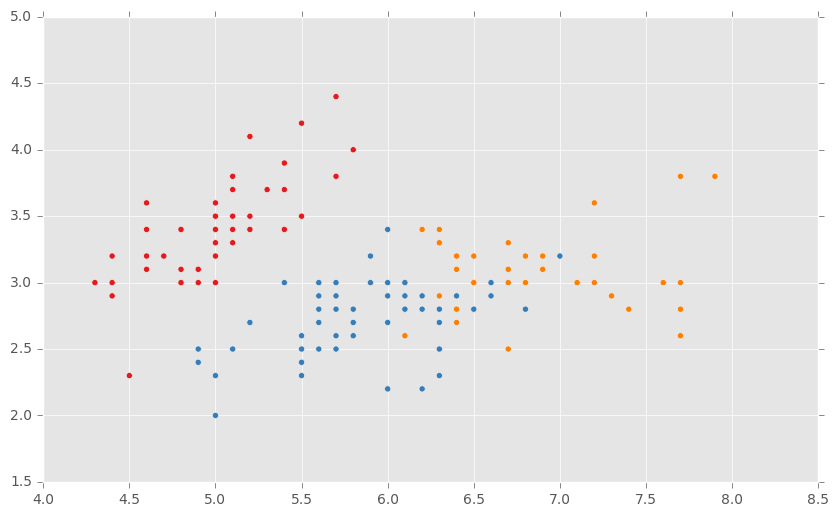

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


In [13]:
y_iris_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_iris_pred,  marker="o", cmap=cmap)
plt.show()
print (y_iris_pred)


This doesn't look too bad'. Let's calculate the error rate:

In [14]:
# you might have to hand-tune this - cluster labels are not deterministic
y_iris_pred_labeled = ['a' if x == 0 else x for x in y_iris_pred]
y_iris_pred_labeled = ['b' if x == 1 else x for x in y_iris_pred_labeled]
y_iris_pred_labeled = ['c' if x == 2 else x for x in y_iris_pred_labeled]

Y_iris_gt_labeled = ['a' if x == 0 else x for x in Y_iris_gt]
Y_iris_gt_labeled = ['b' if x == 1 else x for x in Y_iris_gt_labeled]
Y_iris_gt_labeled = ['c' if x == 2 else x for x in Y_iris_gt_labeled]

print(y_iris_pred_labeled)
print(Y_iris_gt_labeled)

error = 0
for i in range(len(y_iris_pred_labeled)):
    if y_iris_pred_labeled[i] != Y_iris_gt_labeled[i]:
        error += 1

print("items:", len(y_iris_pred_labeled))
print("errors:", error)
print("error rate:", error / len(y_labeled))

['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'b', 'c', 'b', 'c', 'c', 'b', 'b', 'c', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'b', 'c', 'c', 'c', 'b', 'c', 'c', 'b']
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a'

NameError: name 'y_labeled' is not defined

10 % error is OK. We can see that a is clearly separated, while b and c are more intertwined. 